In [1]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian#, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
import os
path = os.getcwd()
import json
from visuals import display_it

import matplotlib as mpl
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # type: ignore
mpl.rcParams['legend.fontsize'] = 10
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
from functions import ChesneyScott, exp_solution
from derivation import Grad, Grad_Hess
from visuals import display_it
from equation import semilinear
from coeff import OU_drift_semi, custom_diff, zero_discount, f_driver, exponential_terminal

In [3]:
'''Germain, Pham, Warin parameters'''
pde_params={'dim':2,
            'kappa':[0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7], # The first kappa=0 because the drift of wealth process is zero
            'theta':[0.,0.4,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1],
            # 'nu':[0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01], #Hung's coefficient
            'nu':[0.,0.2,0.15,0.11,0.12,0.1,0.13,0.14,0.14,0.1], # we do not like vanishing diffusion coefficient
            # 'lb':[0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15],   Hung's params
            'lb':[0.,1.5,1.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15], # New params Make closed form solution more sensitive to time
            # 'lb':[0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0], # CS test
            'rho':[0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
            'eta':.5,
            'T': 1.,#torch.tensor([1.]).to(device),
            }
'''Our parameters'''
# pde_params={'dim':2,
#             'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
#             'theta':torch.tensor([0.,0.1,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
#             # 'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device), #Hung's coefficient
#             'nu':torch.tensor([0.2,0.15,0.11,0.12,0.1,0.13,0.14,0.14,0.1]).to(device), # we do not like vanishing diffusion coefficient
#             # 'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   Hung's params
#             'lb':torch.tensor([0.,1.15,1.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device), # New params Make closed form solution more sensitive to time
#             'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
#             'eta':torch.tensor([1.]).to(device),
#             'T': 1.,#torch.tensor([1.]).to(device),
#             }

'Our parameters'

In [4]:
cs = ChesneyScott(pde_params)
cs.theta,cs.nu,cs.lb,cs.kappa,cs.eta

([0.0, 0.4], [0.0, 0.2], [0.0, 1.5], [0.0, 1.0], 0.5)

In [5]:
input = torch.Tensor([[0.,1.,pde_params['theta'][1]],[0.,1.,.195865],[0.,1.,.2]])
input

tensor([[0.0000, 1.0000, 0.4000],
        [0.0000, 1.0000, 0.1959],
        [0.0000, 1.0000, 0.2000]])

In [6]:
cs_val = cs(input)-1
print("{:.8f}, {:.7f}, {:.7f}".format(cs_val[0].item(),cs_val[1].item(),cs_val[2].item()))

-0.50156831, -0.5513028, -0.5504669


In [7]:
lb_norm2 = -0.5*torch.pow(torch.tensor(pde_params['lb'][:pde_params['dim']]),2).sum()
merton = exp_solution(pde_params,lb_norm2)

In [8]:
merton_val = merton(input)-1
print("{:.7f}, {:.7f}, {:.7f}".format(merton_val[0].item(),merton_val[1].item(),merton_val[2].item()))

-0.1969117, -0.1969117, -0.1969117


In [9]:
t0 = time.time()
num_samples = 2**16
num_time_intervals = 30
max_dim = 10
size = num_samples* max_dim * num_time_intervals
iid = torch.randn(size=[size]).to(device)
print("It takes {:.0f} ms to generate {:,} iid samples.".format(round(1000*(time.time()-t0),6),size))

It takes 239 ms to generate 19,660,800 iid samples.


In [71]:
sim_params={'num_samples':2**12,
        'num_time_intervals': 10,
        'iid':iid,
        'start' : 0.9,  
        'end' : 1.1,
        'num_neurons':6
        }

In [11]:
m = OU_drift_semi(pde_params)
optimal_diff = m.lb_norm/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

In [12]:
semi = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(sim['start']).clone().detach().to(device)
/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(sim['end']).clone().detach().to(device)


In [13]:
semi.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=15000)

At epoch 1, mean loss is 7.66E+01.
Training this epoch takes 44.59 ms. So far: 524.63 ms in training.
At epoch 5000, mean loss is 1.37E+00.
Training this epoch takes 12.69 ms. So far: 75,625.85 ms in training.
At epoch 10000, mean loss is 7.29E-01.
Training this epoch takes 13.6 ms. So far: 150,506.99 ms in training.
At epoch 15000, mean loss is 6.78E-01.
Training this epoch takes 12.61 ms. So far: 217,758.48 ms in training.
Training took 15000 epochs and 217,758.5 ms and the final loss is 6.78E-01.


The $L^2$ distance between the fitted value function at time 0 and closed-form is  1.973E-04.
The $L^2$ distance between the approximated value function at time 0 and closed-form for optimal $\sigma$  is  8.418E-05.


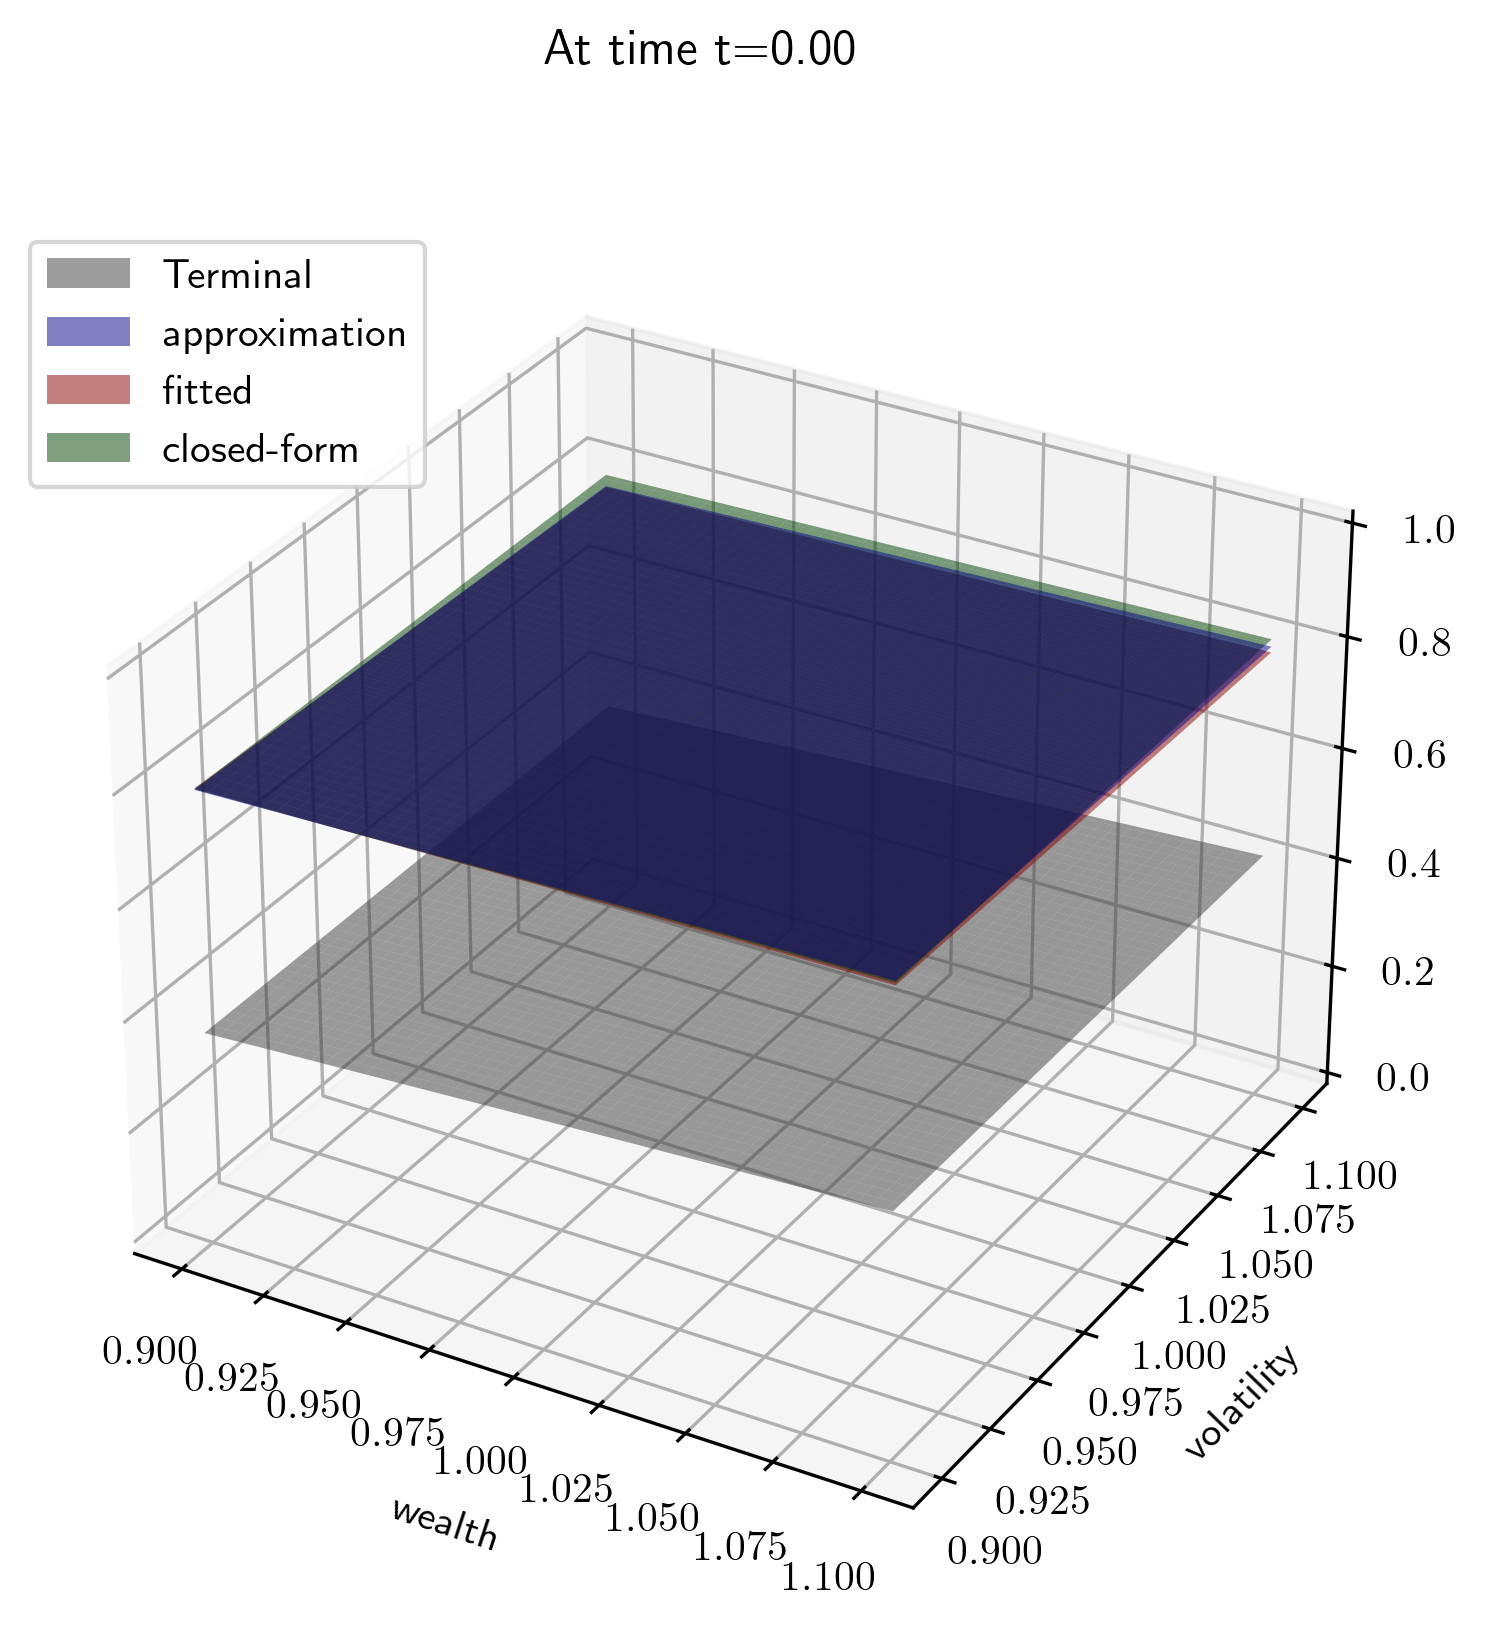

In [14]:
alpha = -0.5*torch.pow(torch.tensor(pde_params['lb'][0:pde_params['dim']]),2).sum()
sol_semi = exp_solution(pde_params,alpha)
display_it(semi,closed_form=sol_semi,zlim=[0.0,1.0]);

In [15]:
torch.abs((semi.Y0(torch.tensor([[1.,0.]]))-merton(torch.tensor([[0.,1.,0.]])))/merton(torch.tensor([[0.,1.,0.]])))*100,torch.abs((semi.Yt(torch.tensor([[0.,1.,0.]]))-merton(torch.tensor([[0.,1.,0.]])))/merton(torch.tensor([[0.,1.,0.]])))*100

(tensor([[6.5758]], grad_fn=<MulBackward0>),
 tensor([[21.3560]], grad_fn=<MulBackward0>))

In [16]:
m = OU_drift_semi(pde_params)
optimal_cs_diff = lambda x: torch.sqrt(torch.pow(m.lb*x[:,1:],2).sum(axis=1))/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_cs_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params,ChesneyScott=True)

In [17]:
optimal_cs_diff(input),input,m.lb,m.lb*input[:,1:]/m.eta

(tensor([1.2000, 0.5876, 0.6000]),
 tensor([[0.0000, 1.0000, 0.4000],
         [0.0000, 1.0000, 0.1959],
         [0.0000, 1.0000, 0.2000]]),
 tensor([0.0000, 1.5000]),
 tensor([[0.0000, 1.2000],
         [0.0000, 0.5876],
         [0.0000, 0.6000]]))

In [72]:
semics = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

In [73]:
semics.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=20000)

At epoch 1, mean loss is 2.27E+01.
Training this epoch takes 34.37 ms. So far: 35.8 ms in training.
At epoch 6666, mean loss is 1.68E-01.
Training this epoch takes 18.73 ms. So far: 129,519.14 ms in training.
At epoch 13332, mean loss is 1.52E-01.
Training this epoch takes 16.54 ms. So far: 257,265.25 ms in training.
At epoch 19998, mean loss is 1.31E-01.
Training this epoch takes 17.26 ms. So far: 381,405.87 ms in training.
Training took 20000 epochs and 381,438.77 ms and the final loss is 1.35E-01.


/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/visuals.py:71: SyntaxWarning: invalid escape sequence '\l'
  ax_log.set_xlabel('$\ln($epoch$)$')
/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/visuals.py:72: SyntaxWarning: invalid escape sequence '\l'
  ax_log.set_ylabel('$\ln($loss$)$');


AttributeError: 'float' object has no attribute 'item'

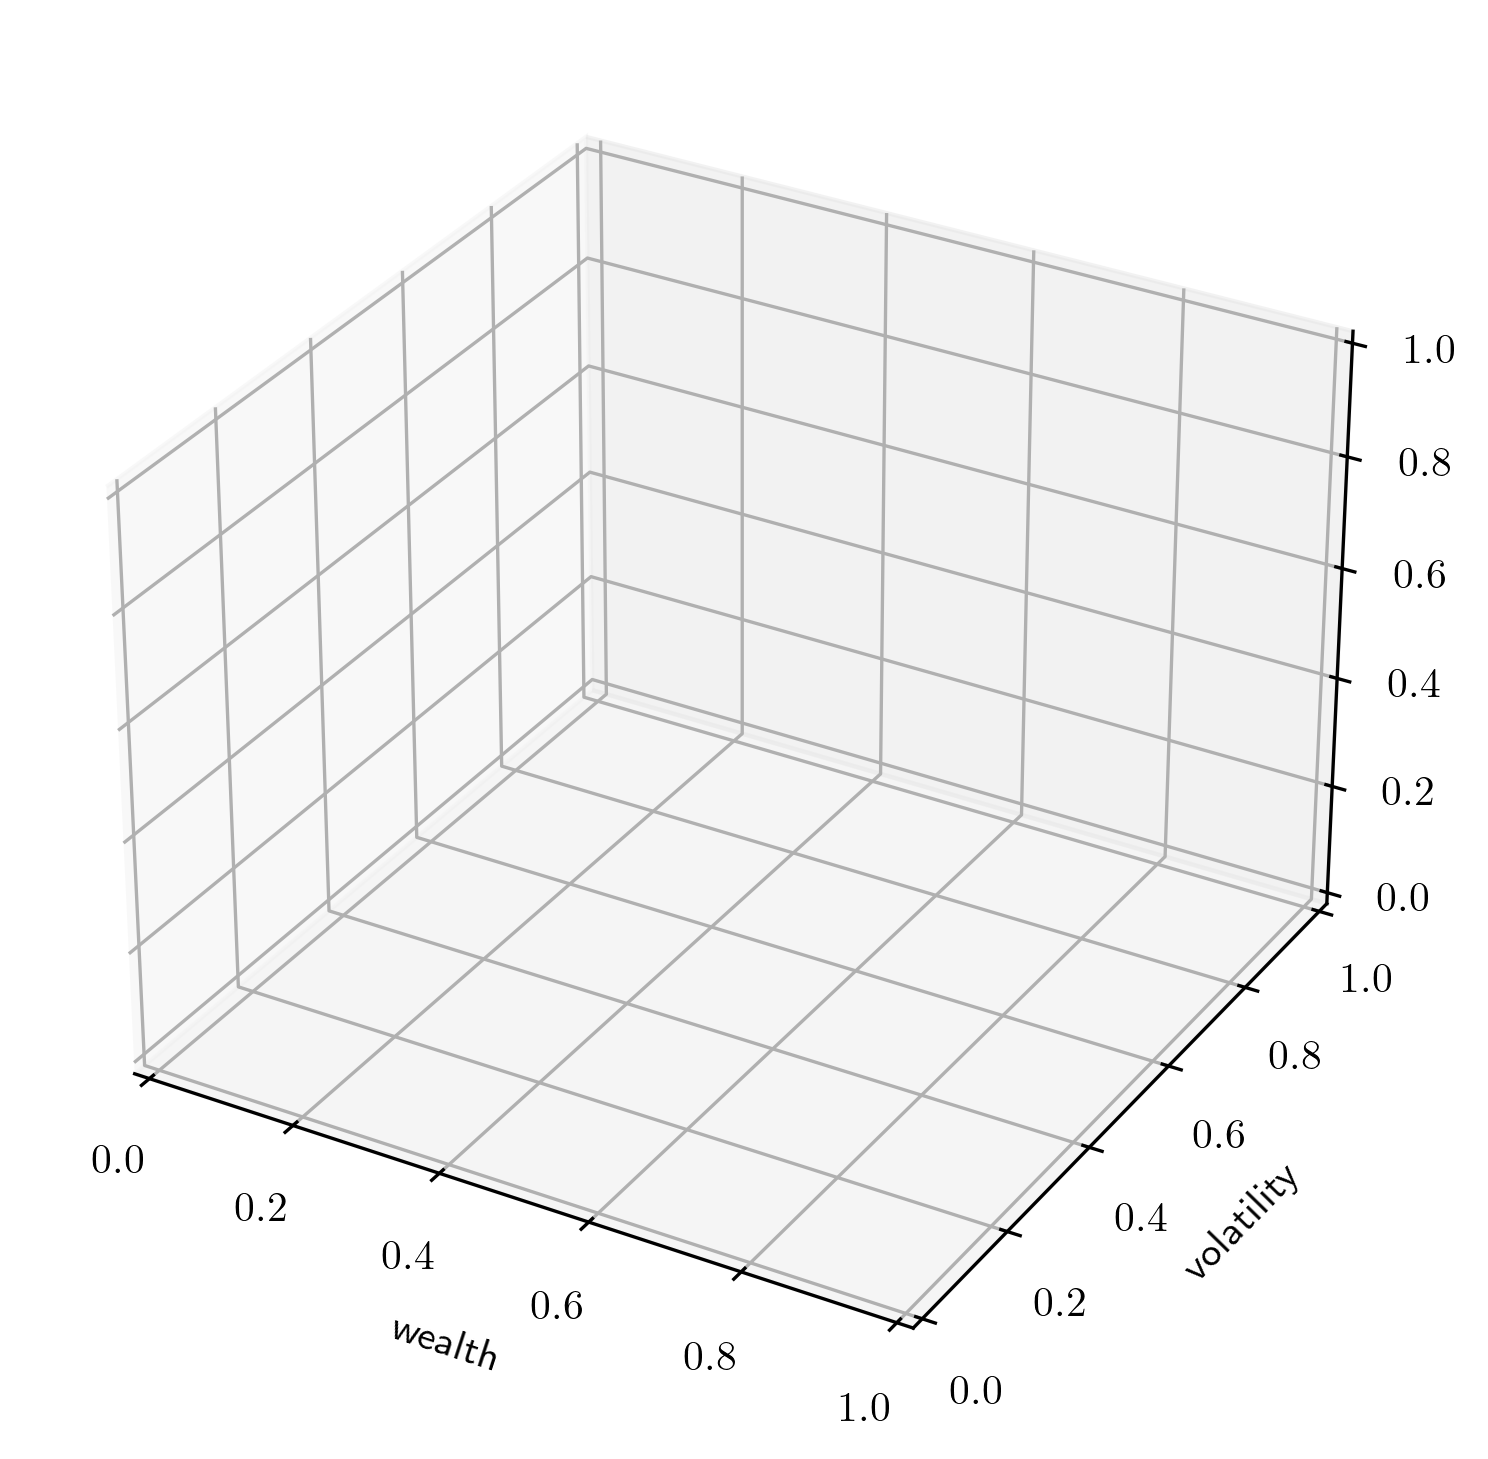

In [74]:
display_it(semics,closed_form=cs);

In [30]:
x = semics.x


tensor([], size=(0, 11))

In [36]:
x[:,:,5]

tensor([[ 0.5000,  3.2700,  0.7513],
        [ 0.5000,  2.5174,  0.7476],
        [ 0.5000, -0.3548,  0.9716],
        ...,
        [ 0.5000,  1.1946,  0.6975],
        [ 0.5000,  2.3679,  0.7512],
        [ 0.5000,  3.0056,  0.7442]])

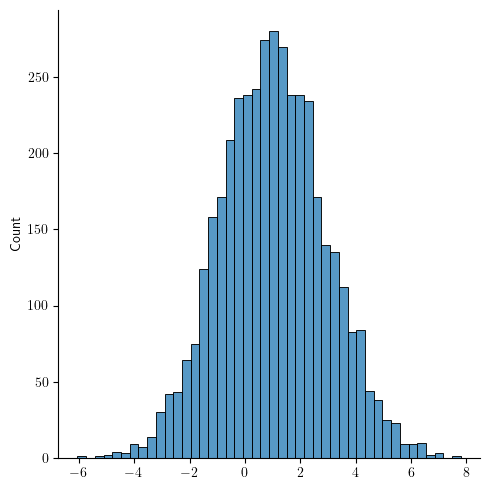

In [62]:
sns.displot(x[:,1,5].numpy());

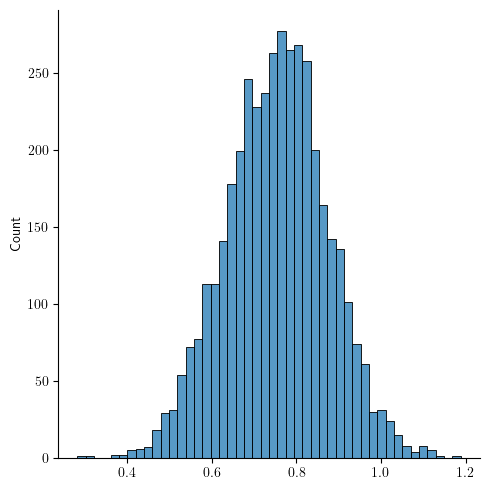

In [63]:
import seaborn as sns 
sns.displot(x[:,2,5].numpy());